In [1]:
import phaseco as pc
import os

os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis")
from N_xi_fit_funcs import *
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence")


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
EXplotSOAEwfP13B.py


Purpose: (Python) Analysis of SOAE waveform data, including 
consideration of phase info to extract several measures of phase coherence

NOTE: (2025.06.13) Freezing this code "as is" to start making plots for revised 
coherence MS (and will save archived vers. in ./Older/ folder); see
.../Manuscripts (CB)/To write/2025 SOAE Phase Coherence/Figures/README.txt
--> Any updates just related to plots will be made to v13B
--> Any updates of substance will be made to a new v14. 

# ==== Notes ==== [vers updates + addit. notes at bottom]
o v.13B:
    + added option to apply a simple window (e.g., Blackman) to corrWF2 as
    per Talmadge et al 1993, but this does not appear useful at present;
    would be good to crosscheck re effect/role of windowTau too
    + added in fig9 to plot entire waveform (along w/ avg RMS) to get a quick
    visual sense for any large artifacts
    + added in "FIG.21" to help better determine SOAE peak freq. locs.
    + added means to analyze .npz simulation waveforms (i.e., noise-driven
    oscs. via EXnoiseDrivenOsc2.py)                                                    
    + adding in new means to plot/compare the spectrally-averaged mags.
    versus the power (i.e., mag. squared)
    *** --> By and large, the two looks the same (shwew!). However, there can
    be diffs. Sometimes it is subtle (e.g., tegu_TG1rearSOAEwf3 peak At ~1.86 kHz),
    and drastic in others (e.g., )
    +  tweaking main plot to add in higher-res mag plot and a noise floor
    (done via a new code block specific to this main fig.)
    + tweaking avgd. phase plot
    +  tweaking plot xi-adjusted time averaging plot
    + added in magTempFact (based upon a suggestion from Seth) to change 
    how the mags are scaled heading into the inverse FT that is then
    used for time averaging; prelim. observations suggest it seems to have 
    an effect of accentuationg peaks when magTempFact=1.2 and likely worth 
    future exploration....
    --> ** preliminary observations suggest detecting sub-NF SOAE structure in:
        > human_AP7RearwaveformSOAE   (see ripples from 4-6 kHz)
        > magTempFact=1.2 
        > Npts= 256*8    AND xiS= 256*2.1 
                                  



Fig.4 waveforms
> human_TH14RearwaveformSOAE

Created on Mon May 16 10:59:20 2022 (v.112updated in 2025.03.25ff)
@author: Cpumpkin (aka C. Bergevin)
"""
import os
import numpy as np
np.complex_ = np.complex128
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import rfft
from numpy.fft import irfft
from scipy import signal

import statsmodels.api as sm
lowess = sm.nonparametric.lowess


# ====================================================
# --- waveform (wf) file info
root= 'paper_analysis/Data/'         # root path to file
fileN = 'ACsb24rearSOAEwfA1.mat'
#fileN= 'Other/testV11.wf1.npz'
#fileN = 'tegu_TG1rearSOAEwf3.txt'  # > Npts= 256*12 and xiS= 256*2.6
#
# +++++++++++++++++++++++++++++++++
# --- v13B bits
NptsB= 256*15    # *[v13B] create a hi-res avgd. mag spec for visualiz.
vertOFF=17   # shift upwards vertically]

magTempFact=2.0   # scaling factor for xi-adjust phase time-averaging {1}
# ** NOTE **: keep at 1 unless explicitly experimenting w/ its effect

# --- mic noise floor files
fileNF = 'testSOAEsupp1.txt'   # file name
vertNFoff= -66  # dB offset for supp file re avgd mags {-65?}
micNF= 0.5    # mic NF line thickness {1}
# ----
dBavgLims= [-110,-82]  #  dB lims for phase-adjusted time-averaging plot
paOFF= 23  # dB to add to xi-adjust phase spec. avg mags plot
NFoffL= -13

# +++++++++++++++++++++++++++++++++
# ---
Npts= 256*4    # tau = length of time window into FFT [in # of points] {256*4} (ideally be 2^N)
xiS= 256*0.5        # xi = number of points to shift over in time to grab next buffer
SR= 44100         # sample rate used to meas. specified wf [Hz] {default = 44100 Hz}
# ---- save computed coherence vals. to file?
saveC= 0   # boolean to save comoputed vals.
fileS= 'junk2.npz'  # file name to save data to
# --- Filter/window the signal?
HPfilter= 0  # boolean to high-pass filter entire wf (0-no, 1-yes) {1}
cutoffF= 0.15  #  cutoff freq. [kHz] {0.15}
order = 6    # filter order {6?}
windowTau= 0   # boolean: apply Hanning window to short time segments re Ctau and Comega {0}
# --- Cxi-windowing
windowXi= 1   # boolean: apply Gaussian window re Cxi {1}
varXiWin= 1   # boolean: xi-variable std for Gaussian window re Cxi {1}
rho= 0.7     # the xi Gaussian window std "rho" parameter {0.7}
winGstdVAL= 125  # window std if varXiWin=0 {125 samples?}
xiWmax= 50000   # max. # of avgs. if using small xi {50000}
# ---
addNoise= 0    # boolean to add noise to waveform before analysis {0}
nAmpl= 0.5   # scaling factor for the noise
coheroMeth= 0  # boolean on how to compute coherogram: 0-avg. phase diffs, 1-avg. diffs. in phase {0?} 
figPhase= 1 # boolean to show avgd. phases: 0-no, 1-yes {1}
figCohero= 0   # boolean to show coherogram: 0-no, 1-yes {0}
figEntireWF= 0 # boolean to show entire time WF: 0-no, 1-yes {0}
# ---
fPlot= [0.4,5]  # freq. limits for plotting [kHz] {[0.2,6], [2,12] for owl}
cPlot= [-0.05,1]
magL=[-1,1]     # mag limits for plotting {[-5,5]}
markB= 1  # boolean to turn off markers for plots (0=no markers) {1}
downSample = 0  # boolean to downsample the data by 1/2
FTnorm= "forward"   # normalization meth. for FFT
# ====================================================
#
# =======================================================================
# ==== bookeeping I (re file loading and plotting logistics)
fname = os.path.join(root,fileN)
if (fileN[-3:]=='mat' and fileN[0:5]!='Model'):   # load in data as a .mat file
    data = scipy.io.loadmat(fname)  # loading in a .mat file
    wf= data['wf']   # grab actual data
elif(fileN[-3:]=='mat' and fileN[0:8]=='Model/MC'):  # load Vaclav's model
    data = scipy.io.loadmat(fname)
    wf= data['oae']  # can also run the 'doae'
    SR= 40000  # SR specified by Vaclav
# --- deal w/ noisy osc files via EXnoiseDrivenOsc2.py
elif(fileN[-3:]=='npz'):
    SR= 10000  # 
    loadData = np.load(fname)
    wf= loadData['arr_0']
    fPlot= [0.2,1]
else:   # load in as a .txt file
    wf = np.loadtxt(fname)  # loading in a .xtt file  
# ---  # Gronengin waveforms (diff. SR)
if (fileN[0:7]=='owl_Owl'):  
    SR= 48000  # SR specified by Pim et al
    print('Assumed SR = 48 kHz (for Groningen owl waveforms)')
# ---  # Gronengin waveforms (diff. SR)
if (fileN[0:8]=='tokay_GG'):  
    SR= 50000  # SR specified by Pim et al
    print('Assumed SR = 50 kHz (for Yuttanas tokay waveforms)')
# --- deal w/ cricket file structure (and SR; see notes at bottom)
if (fileN[0:7]=='cricket'):
    SR= round(1/np.mean(np.diff(wf[:,0])))  # use first column to determine SR
    wf= wf[:,1]  # grab second column 


# --- markers for plotting (if used)  
if markB==0:
    markA=markB=markC= ''
else:
    markA='.'  # C_tau
    markB='+'  # C_omega
    markC='s'  # C_xi 
#
# ==== bookeeping II (re modify whole waveform?)
# NOTE: windowing is done on shorter segments (and thus in analysis loops)
# --- flatten the array if needed (needed for .mat versus .txt read in)
wf= wf.flatten()
# --- downsample by 1/2?
if (downSample==1):
    wf= wf[1::2]  # skip every other point
    SR= SR/2
# --- add in noise to waveform (useful re model sims?)
if (addNoise==1):
    wf= wf.flatten() + float(np.mean(np.abs(wf.flatten())))* nAmpl*np.random.randn(len(wf))
# --- high-pass filtering
if HPfilter==1:
    # REF: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    sos = signal.butter(order, cutoffF*1000,'hp',fs=SR,output='sos')
    wf = signal.sosfilt(sos, wf)
#
# ==== bookeeping III (determine derived analysis params)
# --- determine numb. of segments for spectral averaging (and use as much wf as possible)
M= int(np.floor(len(wf)/Npts))  # numb. of tau time segments (no overlap)
xiS= int(xiS)  # convert xi shift {pts} to int (as may be needed)
###Mxi= int(np.floor(len(wf)/(xiS)-np.ceil(Npts/xiS)-5))  # max> numb. of xi-shifted tau time segments (w/ overlap)
Mxi= int(np.floor(len(wf)/(np.abs(xiS))-np.ceil(Npts/np.abs(xiS))-5))
# ---
if (Mxi>=xiWmax):  # limit # of avgs for xi-shifting
    Mxi= xiWmax

# NOTE: the -5 here is a bit kludgy
# ---
SR= int(SR)
Npts= int(np.floor(Npts))   # length of tau window in numb. of samples
Nt= len(wf)  # total numb. of time points
t= np.linspace(0,(Nt-1)/SR,Nt)   # create assoc. (entire) time array
df = SR/Npts   # freq bin width
freq= np.arange(0,(Npts+1)/2,1)    # create freq. array (for FFT bin labeling)
freq= SR*freq/Npts
indxFl= np.where(freq>=fPlot[0]*1000)[0][0]  # find freq index re above (0.2) kHz
indxFh= np.where(freq<=fPlot[1]*1000)[0][-1]  # find freq index re under (7) kHz
# --- dertermine Gaussin std for xi-windowing
if (varXiWin==1):
    winGstd= rho*xiS/(2*np.sqrt(2*np.log(2)))   # proprtional to xiS such that FWHM ~ xiS
else:
    winGstd= winGstdVAL  # fixed Cxi Gaussian window STD
# --- send some vals to screen for ref
print(f'# of spectral avgs (and tau segments)= {str(M)} ')
print(f'tau window length = {1000*Npts/SR:.2f} ms')
print(f'Xi window shift = {1000*xiS/SR:.2f} ms (or {SR/xiS:.2f} Hz)')
print(f'# of xi-segments= {str(Mxi)} ')
if (windowXi==1):
    print(f'Frac of Gaussian xi-window w/ +/- 2 STDs= {100*winGstd*4/Npts:.2f}%')

if(np.abs(xiS)<=Npts):
    print(f'Xi fract. overlap = {np.sign(xiS)*(1-np.abs(xiS)/Npts)*100:.0f}%')
else:
    print(f'Xi window jump = {np.sign(xiS)*(np.abs(xiS)-Npts)*1000/SR:.1f} ms')
# --- allocate some buffers
storeM= np.empty([int(Npts/2+1),M]) # store away spectral magnitudes
storeP= np.empty([int(Npts/2+1),M])  # store away spectral phases
storeWF= np.empty([int(Npts),M])  # waveform segments (for time-averaging)
storePDtau= np.empty([int(Npts/2+1),M-2])  # smaller buffer for phase diffs re windows
storePDomega= np.empty([int(Npts/2),M])  # phase diff re lower freq bin
storeWFcorr= np.empty([int(Npts),M-1])  # phase-corrected wf
storeT= np.empty([M-2])  # time array for tau-spectrograms
storeTxi= np.empty([Mxi-1])  # time array for xi-spectrograms
storeVStau= np.empty([int(Npts/2+1),M-2])  # time-delay coherence I (for tau-coherogram)
storeVSxi= np.empty([int(Npts/2+1),Mxi-1])  # time-delay coherence II (for xi-coherogram)
storeVSroong= np.empty([int(Npts/2+1),M-2],dtype=np.complex_)  # time-delay coherence (for coherogram)
#
# =======================================================================
# =======================================================================
# ==== Loop I (NO OVERLAPPING): C_tau & C_omega (+spectral averaging)
for n in range(0,M):
    indx= n*Npts  # index offset so to move along waveform to current tau segment
    signalS= np.squeeze(wf[indx:indx+Npts])  # extract current tau segment
    # =======================
    # option to apply a windowing function
    if (windowTau==1):
        signalS=signalS*np.hanning(len(signalS))  
    # --- deal w/ FFT
    spec= rfft(signalS,norm=FTnorm)  
    mag= abs(spec)  # magnitude
    phase= np.angle(spec) # phase
    # --- store away vals
    storeM[:,n]= mag  # spectral mags (re current tau-step)    
    storeP[:,n]= phase # raw phases
    storeWF[:,n]= signalS  # waveform segment
    storePDomega[:,n]= np.diff(phase)  # phase diff re adjacent freq bin (i.e., \phi_j^{{\omega}})
    # ==== deal w/ time-delayed phase diff. (re last/next tau buffer)
    if (n>=1 and n<=M-2):
        # --- grab previous time segment (L)
        indxL= (n-1)*Npts  # previous tau segment index 
        tS= t[indxL]   # time stamp for that point
        signalL=  np.squeeze(wf[indxL:indxL+Npts])  # re-extract last segment
        specL= rfft(signalL,norm=FTnorm) 
        phaseL= np.angle(specL)
        # --- grab next time segment (H) (re coherogram)
        indxH= (n+1)*Npts  # next tau segment index 
        tSh= t[indxH]   # time stamp for that point
        signalH=  np.squeeze(wf[indxH:indxH+Npts])  # re-extract last segment
        specH= rfft(signalH,norm=FTnorm) 
        phaseH= np.angle(specH)
        # ==== now compute phase diff re last segment (phaseDIFF2) or next (phaseDIFF3)
        phaseDIFF2= phase-phaseL # (i.e., \phi_j^{{\tau}})
        phaseDIFF3= phaseH-phase
        # *** NOTE: Need to correct re tau-shift? *** (seems like no)
        # ==== perform "phase adjustment" by replacing phase w/ phase diff re previous buff.
        corrSP= mag*np.exp(1j*phaseDIFF2)    # 
        corrWF= irfft(corrSP, norm=FTnorm)   # convert to time domain
        # ==== compute vector strength (for this segment) using Roongthumskul 2019 recipe
        # NOTE: this is not the primary way to compute coherence (see below)
        Fj= spec/specL
        vsIroong= (Fj/abs(Fj))/abs(Fj/abs(Fj))
        # ==== compute vector strength (for this segment): two ways to do it
        # NOTE: the two yield slightly diff. results (top one seems more straightforward)
        if (coheroMeth==0):  # avg. the two sequential segments 
            zzA= 0.5*(np.sin(phaseDIFF2)+np.sin(phaseDIFF3))
            zzB= 0.5*(np.cos(phaseDIFF2)+np.cos(phaseDIFF3))
        else:    # consider the avg. of the tau-window phases
            zzA= 0.5*(np.sin(phase)+np.sin(phaseL))
            zzB= 0.5*(np.cos(phase)+np.cos(phaseL))
    
        vsI= np.sqrt(zzA**2 + zzB**2)
        # --- store away relevant vals for averaging
        storePDtau[:,n-1]= phaseDIFF2 # phase diff re previous time segment (i.e., \phi_j^{{\tau}})
        storeWFcorr[:,n-1]= corrWF # phase-corrected wf
        storeVSroong[:,n-1]= vsIroong  # time-delayed coherence (aka Gamma)
        storeT[n-1]= tS  # time stamp of tau window onset
        storeVStau[:,n-1]= vsI  # tau-delayed coherence (aka Gamma) --> used in coherogram

tP = np.arange(indx/SR,(indx+Npts-0)/SR,1/SR) # time assoc. for last segment (only for plotting)
# --- C_tau: Phase coherence via vector strength re previous segment
xxTau= np.average(np.sin(storePDtau),axis=1)
yyTau= np.average(np.cos(storePDtau),axis=1)
Ctau= np.sqrt(xxTau**2 + yyTau**2)
# --- C_omega: Phase coherence via vector strength re adjacent freq bin
xxNN= np.average(np.sin(storePDomega),axis=1)
yyNN= np.average(np.cos(storePDomega),axis=1)
Comega= np.sqrt(xxNN**2 + yyNN**2)
freqAVG= freq[1:]- 0.5*np.diff(freq)
# --- calculate avgd. spectra
specAVGm= np.average(storeM,axis=1)  # spectral-avgd MAGs
specAVGmDB= 20*np.log10(specAVGm)    # "  " in dB
specAVGp= np.average(storeP,axis=1)  # spectral-avgd PHASEs

# --- v13B (avg. power instead of mags; 2025.06.24 chat w/ Seth)
#specAVGpower= np.average(storeM**2,axis=1)  # spectral power (re current tau-step)
specAVGpower= np.average(storeM**2,axis=1)-specAVGm**2  # variance (as per 2025.06.25 note from Seth)
specAVGpowerDB= 20*np.log10(specAVGpower) 
specAVGvar= specAVGm**2-specAVGpower
specAVGvarDB= 20*np.log10(specAVGvar) 

# == calc. avgd. VS via Roongthumskul --> this yields equivalent vals as C_tau 
# (i.e., vsRoongAVG=Ctau)
vsRoongAVG= np.average(storeVSroong,axis=1)
vsRoongAVG= abs(vsRoongAVG)


# =======================================================================
# ==== **[v13B] Loop IB (for v13B)
NptsB= int(np.floor(NptsB))   # length of tau window in numb. of samples
dfB = SR/NptsB   # freq bin width
freqB= np.arange(0,(NptsB+1)/2,1)    # create freq. array (for FFT bin labeling)
freqB= SR*freqB/NptsB
# --
MB= int(np.floor(len(wf)/NptsB))  # numb. of tau time segments (no overlap)
storeMB= np.empty([int(NptsB/2+1),M])
for n in range(0,MB):
    indx= n*NptsB  # index offset so to move along waveform to current tau segment
    signalSB= np.squeeze(wf[indx:indx+NptsB])  # extract current tau segment
    # =======================
    # option to apply a windowing function
    if (windowTau==1):
        signalS=signalS*np.hanning(len(signalS))  
    # --- deal w/ FFT
    specB= rfft(signalSB,norm=FTnorm)  
    magB= abs(specB)  # magnitude
    phaseB= np.angle(specB) # phase
    # --- store away vals
    storeMB[:,n]= magB  # spectral mags (re current tau-step)

# --- calculate avgd. spectra
specAVGmB= np.average(storeMB,axis=1)  # spectral-avgd MAGs
specAVGmDBB= 20*np.log10(specAVGmB) 

   
#
# =======================================================================
# =======================================================================
# ==== Loop II (OVERLAPPING): xi-shifting coherence 
storePDxi= np.empty([int(Npts/2+1),Mxi])  # allocate buffer to store phase diffs
storePxi= np.empty([int(Npts/2+1),Mxi])  # allocate buffer to store phases
storeWFcorrXi= np.empty([int(Npts),Mxi-1])  # phase-corrected wf
for n in range(0,Mxi):
    
    # ---- allow for xiS<0 (useful for dual ear analyses)
    if (xiS<0):
        # IN PROGRESS (need to test)
        indxNow= (n+1)*np.abs(xiS)  # index offset so to move along waveform re NOW
        indxShift= (n)*np.abs(xiS)  # index offset re Shift
        
    else:
        indxNow= n*xiS  # index offset so to move along waveform re NOW
        indxShift= (n+1)*(xiS)  # index offset re Shift
    #
    tSxi= t[indxNow]   # time stamp for initial window
    signalNow= np.squeeze(wf[indxNow:indxNow+Npts])  # extract "now" segment
    signalShift= np.squeeze(wf[indxShift:indxShift+Npts])  # extract "Shift" segment
    # --- option to apply a windowing function
    if (windowXi==1):
        #signalNow= signalNow*np.hanning(len(signalNow)) 
        #signalShift= signalShift*np.hanning(len(signalShift)) 
        windowG = signal.windows.gaussian(len(signalNow),std=winGstd)
        signalNow= signalNow*windowG
        signalShift= signalShift*windowG
    # --- deal w/ FFT
    specNow= rfft(signalNow,norm=FTnorm)  
    magNow= abs(specNow)  # magnitude
    phaseNow= np.angle(specNow) # phase
    specShift= rfft(signalShift,norm=FTnorm)  
    magShift= abs(specShift)  # magnitude
    phaseShift= np.angle(specShift) # phase
    # ==== determine phase diff 
    phaseDIFFxi= phaseShift-phaseNow
    # ==== perform "phase adjustment": ref. phaseNow to same time as phaseShift
    if (xiS<0):
        phaseXi= np.angle(np.exp(1*1j*(phaseNow+(2*np.pi*freq*n*(xiS/SR)))))
    else:
        phaseXi= np.angle(np.exp(1j*(phaseNow-(2*np.pi*freq*n*(xiS/SR))))) # corrected for xi-shifting
    #phaseXi= np.angle(np.exp(1j*(phaseNow)))
    # -- xi-shifted time domain "phase-corrected" signal
    #corrSP2= magNow*np.exp(1j*phaseDIFFxi)    # 
    
    # --- v13B --> based upon Seth's suggestion, reweight the mags. going into
    # the adjusted phase time averaging (magTempFact=2 would be "power" 
    #averaging while magTempFact=1 would be magnitude weighting)
    corrSP2= (magNow**magTempFact)*np.exp(1j*phaseDIFFxi)    
    # ----
    
    corrWF2= irfft(corrSP2, norm=FTnorm)   # convert to time domain
    
    # ------
    # apply a window function as per Talmadge et al 1993?
    # --> to first pass, this looks like a bd idea (i.e., peaks become
    # sinc-like)
    if (1==0):
        #corrWF2= corrWF2*np.hanning(len(corrWF2))  
        corrWF2= corrWF2*np.blackman(len(corrWF2))  
    
    storeWFcorrXi[:,n-1]= corrWF2 # phase-corrected wf using xi-shift
    # -- calc. a time-localized coherence meas.  [KLUDGE?]
    zzA= 0.5*(np.sin(phaseShift)+np.sin(phaseNow))
    zzB= 0.5*(np.cos(phaseShift)+np.cos(phaseNow))
    vsIxi= np.sqrt(zzA**2 + zzB**2)
    # --- store away vals
    storePDxi[:,n-1]= phaseDIFFxi
    storePxi[:,n-1]= phaseXi  # 
    storeVSxi[:,n-1]= vsIxi  # xi-shifted coherence (aka Gamma_xi) --> used in coherogram
    storeTxi[n-1]= tSxi  # time stamp of xi window onset
#   
# --- do the averaging of the phase to calculate the xi-based coherence
xxXi= np.average(np.sin(storePDxi),axis=1)
yyXi= np.average(np.cos(storePDxi),axis=1)
Cxi= np.sqrt(xxXi**2 + yyXi**2)
# -- 
#
# =======================================================================      
# ==== deal w/ phase processing (indepenedent of vector stength)
# --- unwrap phase to compute avgd. \phi_j^{{\omega}} 
# unwrapping puts phases differences in [-pi, pi] rather than [-2pi, 2pi]
phaseUWomega= np.unwrap(storeP, axis=0)  # first unwrap w.r.t. frequency axis
phaseDomega= np.diff(phaseUWomega, axis=0)  #  ** second compute diff. re adjacent bin
phaseUWtau= np.unwrap(storeP, axis=1) # ditto w.r.t. time window axis
phaseDtau = np.diff(phaseUWtau, axis=1) # **
# --- also apply to the xi-shifted vers.
phaseUWxi= np.unwrap(storePxi, axis=1)
phaseDxi = np.diff(phaseUWxi, axis=1) 
print(np.max(phaseDxi), np.min(phaseDxi))
# --- now compute avgd vers
storePDomegaAVG= np.average(np.abs(phaseDomega),axis=1)  # lastly avg. the abs val. over windows
print(f"Num of omega windows = {phaseDomega.shape[1]}")
storePDtauAVG= np.average(np.abs(phaseDtau),axis=1)
print(f"Num of tau windows = {phaseDtau.shape[1]}")
storePDxiAVG= np.average(np.abs(phaseDxi),axis=1) # no further corr. needed (since handled earlier)
#storePDxiAVGcorr= np.angle(np.exp(1j*(storePDxiAVG-(2*np.pi*freq*(xiS/SR)))))
# ==== handle time-averaging of various phase-adjusted waveforms
# --- sans phase corr.
timeAVGwf= np.average(storeWF,axis=1)  # time-averaged waveform
specAVGwf= rfft(timeAVGwf,norm=FTnorm)    # magnitude
specAVGwfDB= 20*np.log10(abs(specAVGwf))  # "  " in dB
# --- tau phase-adjusted version 
timeAVGwfCorr= np.average(storeWFcorr,axis=1)  # time-averaged waveform
specAVGwfCorr= rfft(timeAVGwfCorr,norm=FTnorm)  # magnitude
specAVGwfCorrDB= 20*np.log10(abs(specAVGwfCorr))  # "  " in dB
# --- xi phase-adjusted version 
timeAVGwfCorrXi= np.average(storeWFcorrXi,axis=1)  # time-averaged waveform
specAVGwfCorrXi= rfft(timeAVGwfCorrXi,norm=FTnorm)  # magnitude
specAVGwfCorrXiDB= 20*np.log10(abs(specAVGwfCorrXi))  # "  " in dB
# --- complex-averaged vers. of "phase-corrected" version
# (alternative reality check re performing the irfft and rfft to get specAVGwfCorr)
specAVGpcS= np.average(storeM[:,1:-1]*np.exp(1j*storePDtau),axis=1)  # 
# =======================================================================
# Compute a combined measure of the mags & phases as a crude SOAE "presence" meas.
#mGrad= np.gradient(abs(specAVGwf))  # gradient of avgd. spec. mags
mGrad= np.gradient(20*np.log10(abs(specAVGwf)))  # gradient of avgd. spec. mags (in dB)
pGrad= np.gradient(abs(storePDxiAVG))  # gradient of avgd. xi-phase
# --- rectify? (i.e., make all vals positive) 
# {1 helps visually, but perhpas at loss of info/generality)
if (1==1):
    mGrad= np.abs(mGrad)
    pGrad= np.abs(pGrad)

mpGradProd= mGrad*pGrad  # product of their slopes
mpGradProd[0:10]=0  # set first several vals to zero so to ignore (kludgy)
combinedMP= mpGradProd
#
# =======================================================================  
# Package numbers for export to file (for when saveC=1)
# REF: https://stackoverflow.com/questions/11637045/complex-matlab-like-data-structure-in-python-numpy-scipy
# REF: https://numpy.org/doc/stable/reference/generated/numpy.savez.html
if (saveC==1):
    # --- store into a structure (redundant at present)
    class structtype():
        pass
    storeC= structtype()
    storeC.file= fileN
    storeC.params= [SR,Npts,xiS]
    storeC.freq= freq/1000  # [kHz]
    storeC.mags= specAVGmDB  # avgd. spectals mags. [dB]
    storeC.Ctau= Ctau      # tau-coherence
    storeC.Comega= Comega     # omega-coherence (i.e., NN-ref)
    storeC.Cxi= Cxi      # xi-coherence
    # ==== save as a npz file
    #from tempfile import TemporaryFile
    #outfile = TemporaryFile()
    np.savez(fileS, fileN,[SR,Npts,xiS],freq/1000,specAVGmDB,Ctau,Comega,Cxi)
    #np.savez(fileS,storeC)
#
# ======================================================================= 
# [v13B code] 

# === estimate a mic "noise floor" from the data to add to the avgd. mag plot via a lowess
# --> a decent try, but abadoned as the fit is terrible in the big gap inbetween
if (1==0): 
    # -- limtis for freqs [kHz] beLOW and ABOVE SOAE activity to include in lowess
    fLimLOW= [0.25,1.1]
    fLimABOVE= [4.6,6]
    sigmaNF= 0.3  # local-ness factor for lowess NF est.  {0.1-0.2}
    # -- grab vals in that range for fit
    indxBLOWl= np.where(freq>=fLimLOW[0]*1000)[0][0]  
    indxBLOWh= np.where(freq<=fLimLOW[1]*1000)[-1][-1] 
    indxBABOVEl= np.where(freq>=fLimABOVE[0]*1000)[0][0]  
    indxBABOVEh= np.where(freq<=fLimABOVE[1]*1000)[-1][-1] 
    freqNFfit= np.append(freq[indxBLOWl:indxBLOWh],freq[indxBABOVEl:indxBABOVEh])
    magNFfit= np.append(specAVGmDB[indxBLOWl:indxBLOWh],specAVGmDB[indxBABOVEl:indxBABOVEh])
    # --- creating est. points to fill the gap..... (kludge!)
    freqNFfit= np.append(freqNFfit,[2000,3000,4000])
    magNFfit= np.append(magNFfit,[-91,-92,-91])
    # -- now do a lowess to those vals to get a "NF" fit curve
    fitNF= lowess(magNFfit,freqNFfit,frac=sigmaNF)
    # --> plot freqNFfit vs fitNF[:,1]

if 0: # NOISE FLOOR
    # === instead use a "SOAEsupp" file w/ probe coupled to a tube
    fnameNF = os.path.join(root,fileNF)
    dataNF = np.loadtxt(fnameNF)
    # ==== 
    freqNF = dataNF[:,0]
    magNF = dataNF[:,1]
    magNF= magNF+vertNFoff

    # =======================================================================
    # =======================================================================
    # ==== visualize
    plt.close("all")
    # - create a title string contain. filename + key coherence params
    #titC= fileN[:-4]+": "+r'$ \tau=$'+str(1000*Npts/SR)+" & "+r'$ \xi=$'+str(1000*xiS/SR)+" ms"
    titC= fileN[:-4]+": "+r'$ \tau=$'+f'{1000*Npts/SR:.2f}'+" & "+r'$ \xi=$'+f'{1000*xiS/SR:.2f}'+" ms"
    #titC= fileN[:-4]+": "+r'$ \tau=$'+{1000*Npts/SR}+" & "+r'$ \xi=$'+str(1000*xiS/SR)+" ms"
    #print(f'Xi window shift = {1000*xiS/SR:.2f} ms (or {SR/xiS:.2f} Hz)')
titC= fileN[:-4]+": "+r'$ \tau=$'+f'{1000*Npts/SR:.2f}'+" & "+r'$ \xi=$'+f'{1000*xiS/SR:.2f}'+" ms"
# --- * FIG [v13B] - entire time waveform to see if there are lots of noisy excursions
if figEntireWF==1:
    avgWGlong= np.sqrt(np.average([wf**2]))
    fig9, ax9 = plt.subplots()
    plt.plot(t,wf,linestyle='-.',color='k',label='Raw waveform')
    plt.plot([t[0],t[-1]],[avgWGlong,avgWGlong],'r--',label='avg. RMS')
    plt.plot([t[0],t[-1]],[-avgWGlong,-avgWGlong],'r--')
    fig8= plt.xlabel('Time [s]',fontsize=12)
    fig8= plt.ylabel('Mic signal [V]',fontsize=12) 
    fig8= plt.title(fileN,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    fig8= plt.grid()
    fig8= plt.legend()

# --- FIG - single waveform and assoc. spectrum
if 1==0:
    fig1, ax1 = plt.subplots(2,1)
    ax1[0].plot(tP,signalS,linestyle='-', marker=markA, 
                color='k',label='wf')
    ax1[0].set_xlabel('Time [s]')  
    ax1[0].set_ylabel('Signal [arb]') 
    ax1[0].set_title('Last waveform used for averaging')
    if (windowXi==1):  # incl. (scaled) Gaussian window used for xi-calcs.
        ax1[0].plot(tP,windowG*np.max(signalS),linestyle='--',
                    color='lime',label='Xi filter')
    ax1[0].grid()
    ax1[1].plot(freq/1000,20*np.log10(spec),'r',label='X',marker=markB)
    ax1[1].set_xlabel('Frequency [kHz]')  
    ax1[1].set_ylabel('Magnitude [dB]') 
    ax1[1].set_title('Spectrum')
    ax1[1].grid()
    ax1[1].set_xlim([0,8])
    fig1.tight_layout(pad=1.5)
#
# ==== *** FIG - coherence v.13B
if 0:
    fig5, ax5  = plt.subplots(2,1)
    # -- **[v13B]
    if (1==1):  # {1==0}
        ax5[0].plot(freqB/1000,specAVGmDBB+vertOFF,linestyle='-', lw=3,
                       color='r',alpha=0.3,label='(hi-res)Spectral Avg.')
    # === mags. on top
    ax5[0].plot(freq/1000,specAVGmDB,linestyle='-', marker=markA, 
                   ms=7,color='k',label='Spectral Avg.')
    
    # -- include mic noise floor
    if 0:  # {1==0}
        ax5[0].plot(freqNF/1000,magNF,linestyle='--',color='g',lw=micNF,
                    alpha=0.5,label='Est. Noise Floor')
    #
    #ax5[0].set_xlabel('Frequency [kHz]')  
    fracLS= 0.05  # scaling fraction to help w/ vert. lims {0.05}
    ax5[0].set_ylabel('Magnitude [dB]',fontsize=12)
    ax5[0].set_title(titC,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    ax5[0].set_xlim(fPlot)
    ax5[0].grid()
    ax5[0].set_ylim([np.min(specAVGmDB[indxFl:indxFh])+magL[0]-5,
                    np.max(specAVGmDB[indxFl:indxFh])+magL[1]+2])
    # ===  coherence on bottom
    Lb1= ax5[1].plot(freq/1000,Ctau,linestyle='-', 
                   marker=markA,color='k',label=r'$C_{\tau}$')
    # -- Turn below on to demonstrate vsRoongAVG=Ctau equivalence
    if (1==0):  # {1==0}
        Lb1= ax5[1].plot(freq/1000,vsRoongAVG,linestyle='--', 
                         marker='',color='g',label='Roong VS')
    Lb2= ax5[1].plot(freqAVG/1000,Comega,'r',lw=1,linestyle='--',
                   marker=markB,label=r'$C_{\omega}$',markersize=4)
    # --- use right y-axis for C_xi
    ax5b = ax5[1].twinx()
    Lb3= ax5b.plot(freq/1000,Cxi,'b',lw=1,linestyle='-.',
                   marker=markC,label=r'$C_{\xi}$',markersize=2)
    if (1==0): # {1==1}
        # unique right axis limits for C_xi
        #ax5b.set_ylim([(1-fracLS)*np.min(Cxi), (1+fracLS)*np.max(Cxi)])
        ax5b.set_ylim([cPlot[0], (1+fracLS)*np.max(Cxi)])
    else:
        # same axis limits on both sides
        #ax5b.set_ylim([-0.05,np.max([(1+fracLS)*np.max(Ctau),
        #                           (1+fracLS)*np.max(Comega)])])
        ax5b.set_ylim([-0.05,1.05])
    ax5[1].set_xlabel('Frequency [kHz]',fontsize=12)  
    ax5[1].set_ylabel(r'Coherence ($C_{\tau}$ & $C_{\omega}$)',fontsize=12) 
    ax5b.set_ylabel(r'$C_{\xi}$',fontsize=12,color='b') 
    ax5[1].grid()
    ax5[1].set_xlim(fPlot)
    ax5[1].set_ylim(cPlot)
    #ax5[1].set_ylim([-0.05,np.max([(1+fracLS)*np.max(Ctau),
    #                               (1+fracLS)*np.max(Comega)])]) 
    #ax5[1].set_ylim([-0.05,1.05])
    LbT = Lb1+Lb2+Lb3  # deal w/ legend given multiple ordinates
    labelF5 = [l.get_label() for l in LbT]
    ax5[1].legend(LbT,labelF5,loc="best")
    #ax5[1].legend(loc="upper right")
    plt.tight_layout()
    



# ==== * FIG [v13B] - compare spec.-avgd. mags versus power (i.e., PSD) vs variance
if 1==0:
    fig8, ax8 = plt.subplots()
    
    sN1 = plt.plot(freq/1000,specAVGmDB,linestyle='-',color='k',label='Mags.')
    fig8= plt.xlabel('Frequency [kHz]',fontsize=12)
    fig8= plt.ylabel('Magnitude [dB]',fontsize=12) 
    fig8= plt.title(fileN,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    fig8= plt.grid()
    fig8= plt.xlim(fPlot)
    fig8= plt.ylim([np.min(specAVGmDB[indxFl:indxFh])-5,
                    np.max(specAVGmDB[indxFl:indxFh])+5])
    ax8b = ax8.twinx()  # second ordinate (same abscissa)
    sN2 = plt.plot(freq/1000,specAVGpowerDB,linestyle='-',color='r',label='Power')
    sN3 = plt.plot(freq/1000,specAVGvarDB,linestyle='--',color='lime',label='Variance')
    sNT = sN1+sN2+sN3
    labelSN = [l.get_label() for l in sNT]
    ax8.legend(sNT,labelSN,loc="upper right")
    ax8b.set_ylabel('PSD [dB]',fontsize=12,color='r')
    ax8b.set_ylim([np.min(specAVGpowerDB[indxFl:indxFh])-5,
                    np.max(specAVGpowerDB[indxFl:indxFh])+5])
    plt.tight_layout()
    
    
# ==== * FIG [v13B] - spectral mags v.3: spectral-avgd vs time-avgd w/ phase corr
# ---> Now focuses chiefly on C_xi "phase adjustment" rather than Ctau
if 1==0:
    fig2, ax2 = plt.subplots()
    sp1 = plt.plot(freq/1000,specAVGmDB,linestyle='-',marker='none', 
                   alpha=0.7,color='k',label='Spectral Avg.')
   
    sp1 = plt.plot(freq/1000,specAVGwfCorrXiDB+paOFF,linestyle='-',
                alpha=0.4,lw=2.2,color='r',label=r'Time Avg. via $\xi$-adjust.')
    if (1==0):  # {1==0}
        ax2.plot(freqNF[0::16]/1000,magNF[0::16]+NFoffL,linestyle='-',color='g',lw=micNF,
                    alpha=0.85,label='Est. Noise Floor')
    fig2= plt.xlabel('Frequency [kHz]',fontsize=12)
    fig2= plt.ylabel('Magnitude [dB]',fontsize=12) 
    fig2= plt.title(titC,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    fig2= plt.grid(True, which="both", ls="-", color='0.5')
    fig2= plt.legend()
    fig2= plt.xlim(fPlot)
    fig2= plt.ylim(dBavgLims)
    plt.tight_layout()
#
r"""
# ==== * FIG [v13B] - spectral mags v.2: spectral-avgd vs time-avgd w/ phase corr
# ---> Now focuses chiefly on C_xi "phase adjustment" rather than Ctau
if 1==1:
    fig2, ax2 = plt.subplots()
    sp1 = plt.plot(freq/1000,specAVGmDB,linestyle='-',marker=markA, 
                   alpha=0.4,color='k',label='Spectral Avg.')
    #sp1B = plt.plot(freq/1000,specAVGwfCorrDB,linestyle='--', markersize=4,
    #               marker=markB,color='b',label='Temporal Avg: tau-adjust.')
    sp1 = plt.plot(freq/1000,specAVGwfCorrXiDB+paOFF,linestyle='--',
                alpha=0.6,lw=2,color='r',label=r'Time Avg. via $\xi$-adjust.')
    fig2= plt.xlabel('Frequency [kHz]',fontsize=12)
    fig2= plt.ylabel('Magnitude [dB]',fontsize=12) 
    fig2= plt.title(fileN,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    fig2= plt.grid()
    fig2= plt.xlim(fPlot)
    #fig2= plt.ylim([np.min(specAVGmDB[indxFl:indxFh])-5,
    #                np.max(specAVGmDB[indxFl:indxFh])+5])
    
    
    fig2= plt.ylim([-96,-74])

    # ax2b = ax2.twinx()  # second ordinate (same abscissa)
    # sp2 = plt.plot(freq/1000,specAVGwfCorrXiDB+paOFF,linestyle='--',
    #             alpha=0.6,lw=2,color='r',label=r'Time Avg. via $\xi$-adjust.')
    
    # spT = sp1+sp2
    
    # labelS = [l.get_label() for l in spT]
    # ax2.legend(spT,labelS,loc="upper right")
    # ax2b.set_ylabel(r'$\xi$-adjusted Magnitude [dB]',fontsize=12,color='r')
    # #ax2b.set_ylim(dBavgLims)

    plt.tight_layout()
#
"""

# ==== ** "FIG.21" [v13B] - time-avgd w/ phase corr spectral mags AND C_xi
# --->
if 0:
    fig21, ax21 = plt.subplots()
   
    sp1 = plt.plot(freq/1000,specAVGwfCorrXiDB+paOFF,marker=markC,linestyle='-',
                   markersize=2,alpha=0.4,lw=2.2,color='r',label=r'Time Avg. via $\xi$-adjust.')
    ax21b = ax21.twinx()
    Lb3= ax21b.plot(freq/1000,Cxi,'b',lw=1,linestyle='-.',
                   marker=markC,label=r'$C_{\xi}$',markersize=2)
    ax21b.set_ylim([cPlot[0],0.3])
    fig21= plt.xlabel('Frequency [kHz]',fontsize=12)
    fig21= plt.ylabel('Magnitude [dB]',fontsize=12) 
    fig21= plt.title(titC,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
    fig21= plt.grid()
    fig21= plt.legend()
    fig21= plt.xlim(fPlot)


# # ==== * FIG - spectral mags v.2: spectral-avgd vs time-avgd w/ phase corr
# # ---> Now focuses chiefly on C_xi "phase adjustment" rather than Ctau
# if 1==1:
#     fig2, ax2 = plt.subplots()
#     sp1 = plt.plot(freq/1000,specAVGmDB,linestyle='-',marker=markA, 
#                    color='k',label='Spec. Avg.')
#     sp1B = plt.plot(freq/1000,specAVGwfCorrDB,linestyle='--', markersize=4,
#                    marker=markB,color='b',label='Temporal Avg: tau-adjust.')
#     fig2= plt.xlabel('Frequency [kHz]',fontsize=12)
#     fig2= plt.ylabel('Magnitude [dB]',fontsize=12) 
#     fig2= plt.title(fileN,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
#     fig2= plt.grid()
#     fig2= plt.xlim(fPlot)
#     fig2= plt.ylim([np.min(specAVGmDB[indxFl:indxFh])-5,
#                     np.max(specAVGmDB[indxFl:indxFh])+5])
#     ax2b = ax2.twinx()  # second ordinate (same abscissa)
#     sp2 = plt.plot(freq/1000,specAVGwfCorrXiDB,linestyle='-.', markersize=3,
#                 marker=markC,color='r',label='Temporal Avg: xi-adjust.')
    
#     spT = sp1+sp1B+sp2
#     # NOTE: set boolean to 0 unless checking equivalence on specAVGwfCorr and specAVGpcS
#     # --> this simply demonstrates that specAVGpcS is equiv. to specAVGwfCorrDB
#     if (1==0): # {0}
#         sp3 = ax2b.plot(freq/1000,20*np.log10(abs(specAVGpcS)),
#                          label='(Phase-Corr) Spec. Avg.')
#         spT = sp1+sp1B+sp2+sp3
    
#     labelS = [l.get_label() for l in spT]
#     ax2.legend(spT,labelS,loc="lower right")
#     ax2b.set_ylabel('Magnitude [dB] re xi-adjust.',fontsize=12)
#     plt.tight_layout()
# #

# --- * time-averaged. spectral mags: phase corr vs no corr.
if 1==0:
    fig3 = plt.subplots()
    fig3= plt.plot(freq/1000,specAVGwfDB,linestyle='-', 
                   marker=markA,color='k',label='Uncorr.')
    fig3= plt.plot(freq/1000,specAVGwfCorrDB,linestyle='--', 
                   marker=markB,color='r',label='tau_Corrected')
    fig3= plt.plot(freq/1000,specAVGwfCorrXiDB,linestyle='-.', 
                   marker=markB,color='b',label='xi_Corrected')
    #plt.plot(freq/1000,20*np.log10(abs(specAVGpcS)),label='Corrected Spec-Avg.',color='m')
    fig3= plt.xlim(fPlot)
    fig3= plt.xlabel('Frequency [kHz]')
    fig3= plt.ylabel('Magnitude [dB]') 
    fig3= plt.title(fileN) 
    fig3= plt.grid()
    #plt.ylim([-60,10])
    fig3= plt.legend()
    plt.tight_layout()
#
# --- * Gradient of spec.-avgd peaks & xi-phase to yield combined "presence" meas.
if 1==0:
    fig55, ax55   = plt.subplots(2,1)
    ax55[0].plot(freq/1000,specAVGmDB,linestyle='-', marker=markA, 
                   color='k',label='Spectral Avg.')
    fracLS= 0.05  # scaling fraction to help w/ vert. lims {0.05}
    ax55[0].set_ylabel('Magnitude [dB]',fontsize=12)
    ax55[0].set_title(titC,fontsize=10,loc='right') 
    ax55[0].set_xlim(fPlot)
    ax55[0].grid()
    ax55[0].set_ylim([np.min(specAVGmDB[indxFl:indxFh])+magL[0],
                    np.max(specAVGmDB[indxFl:indxFh])+magL[1]])
    # Note: Initial analysis suggests no need to plot combinedMP in dB
    ax55[1].plot(freq/1000,combinedMP,linestyle='-', markersize=2,
                   marker=markC,color='b',label='Uncorr.') 
    ax55[1].set_xlim(fPlot)
    ax55[1].set_xlabel('Frequency [kHz]')
    ax55[1].set_ylabel('Comb. Mag & Phase metric') 
    ax55[1].grid()
    plt.tight_layout()
#    
# ==== * FIG -  spectrogram & coherogram pair
if figCohero==1:
    # --- a few derived vals
    tG,fG = np.meshgrid(storeT,freq/1000)  # tau-vers. vals
    tGxi,fGxi = np.meshgrid(storeTxi,freq/1000)  # xi-vers. vals
    spectrogV= 20*np.log10(storeM[:,2:])  # grab last M-1 spec. mags and convert to dB
    # ---
    fig6, (ax1, ax2) = plt.subplots(nrows=2)
    # --- spectrogram
    cs= ax1.pcolor(tG,fG,spectrogV,cmap='jet')
    cbar1= fig6.colorbar(cs,ax=ax1)
    cbar1.ax.set_ylabel('Magnitude [dB]')
    #cs.set_clim(-20,10)  # comment to let limits auto-set
    ax1.set_ylim(fPlot)
    ax1.set_title('Spectrogram')
    ax1.set_ylabel('Frequency [kHz]')
    ax1.set_xlabel('Time [s]') 
    # --- tau-coherogram
    cs2= ax2.pcolor(tG,fG,storeVStau,cmap='viridis', vmin=0, vmax=1)
   
    cbar2=fig6.colorbar(cs2,ax=ax2)
    cbar2.ax.set_ylabel('Coherence')
    ax2.set_ylim(fPlot)
    cs2.set_clim(0.3,1)
    ax2.set_title('tau-Coherogram')
    ax2.set_ylabel('Frequency [kHz]')
    ax2.set_xlabel('Time [s]') 
    # --- xi-coherogram
    #cs3= ax2.pcolor(tGxi,fGxi,storeVSxi,cmap='viridis', vmin=0, vmax=1)
    plt.tight_layout()
#
# ==== ** FIG -  Avg. phase diffs: adjacent freq bin vs adjacent window
#HERE
# if figPhase:
#     fig7, ax7 = plt.subplots(2,1)
#     ax7[0].plot(freqAVG/1000,storePDomegaAVG,linestyle='--',marker=markB, 
#                    color='r',label=r'$\phi^{\omega}$')
#     ax7[0].plot(freq/1000,storePDtauAVG,linestyle='-',marker=markA, 
#                    color='k',label=r'$\phi^{\tau}$')
#     ax7[0].plot(freq/1000,storePDxiAVG,linestyle='-.',marker=markC, 
#                    color='b',label=r'$\phi^{\xi}$',markersize=2)
#     ax7[0].set_xlabel('Frequency [kHz]',fontsize=12)
#     ax7[0].set_ylabel(r"$\langle|\phi_j|\rangle$ [rads]",fontsize=12) 
#     ax7[0].legend(loc="lower right")
#     ax7[0].set_title(titC,fontsize=8,loc='right',color=[0.5,0.5,0.5]) 
#     ax7[0].grid()
#     ax7[0].set_xlim(fPlot)
#     fig7.delaxes(ax7[1])


# # ==== ** FIG -  Avg. phase diffs: adjacent freq bin vs adjacent window
# if figPhase==1:
#     fig7, ax7 = plt.subplots()
#     sp1 = plt.plot(freqAVG/1000,storePDomegaAVG,linestyle='--',marker=markB, 
#                    color='r',label=r'$\phi^{\omega}$')
#     sp2 = plt.plot(freq/1000,storePDtauAVG,linestyle='-',marker=markA, 
#                    color='k',label=r'$\phi^{\tau}$')
#     sp3 = plt.plot(freq/1000,storePDxiAVG,linestyle='-.',marker=markC, 
#                    color='b',label=r'$\phi^{\xi}$',markersize=2)
#     fig2= plt.xlabel('Frequency [kHz]',fontsize=12)
#     fig2= plt.ylabel(r"$\langle|\phi_j|\rangle$ [rads]",fontsize=12) 
#     ax7.legend(loc="lower right")
#     fig2= plt.title(titC,fontsize=10,loc='right') 
#     fig2= plt.grid()
#     fig2= plt.xlim(fPlot)


# === FIG (c/o Seth) - Avg. phase diff for C_omega vs C_omega vs mags (SI figure 1+2)
if 1==0:
    # set up plots and plot parameters
    fig, ax = plt.subplots(2, 1)
    fs = "12" # set font size for all labels
    means_label = r"$\langle|\phi_j^{{\omega}}|\rangle$" # define the <|phase diffs|> latex string
    # -- twin the axes so we can add a second y axis to each subplot
    axt2 = ax[0].twinx()
    axb2 = ax[1].twinx()
    # TOP SUBPLOT
    axt2.plot(freqAVG/1000, Comega, label=r"$C_{{\omega}}$", marker=markB, color='m', lw=1)
    axt2.set_ylabel('Vector Strength', fontsize=fs)
    axt2.legend(loc="upper right", fontsize=fs)
    ax[0].plot(freqAVG/1000, storePDomegaAVG, label=means_label, color='black', marker=markA, lw=1)
    ax[0].set_ylabel(means_label, fontsize=fs)
    ax[0].legend(loc="upper left", fontsize=fs)
    # BOTTOM SUBPLOT
    axb2.plot(freq/1000, specAVGmDB, label="Magnitude", color='r', marker=markB, lw=1)
    axb2.set_ylabel('Magnitude [dB]', fontsize=fs)
    axb2.legend(loc="lower right", fontsize=fs)
    ax[1].plot(freqAVG/1000, storePDomegaAVG, label=means_label, color='black', marker=markA, lw=1)
    ax[1].set_ylabel(means_label, fontsize=fs)
    ax[1].legend(loc="lower left", fontsize=fs)
    # set title, xlims, and xlabels
    ax[0].set_title(fileN, fontsize="14")
    for i in [0, 1]:
        ax[i].set_xlabel("Frequency [kHz]", fontsize=fs)
        ax[i].set_xlim(fPlot)
        ax[i].set_ylim(0, np.pi)
    plt.tight_layout()
plt.show()


    
"""
==== Notes (cont) ====
o "phase coherence" = vector strength (as defined by V&D08 eq.20), 
computed several different ways:
1. time-delayed (C_tau): for a given freq. bin, ref = same bin for previous 
    time buffer
2. nearest-neighbor (C_omega): ref. = neighboring (lower) freq. bin
3. "coherogram" re plus/minus one time buffer
 ---
 o determines max number of avgs possible for averaging (M)
 o allows data to be read in as .mat file or .txt file
 o when converting txt files to .mat (via Matlab; roughly halves 
   the filesize), in Matlab type:
    > wf=load('fileName.txt');
    > save('fileName.mat','wf')
o tree cricket files are not SOAE (i.e., acoustic), but vibrometry where
the first column is time [s] and the second measured spontaneous 
oscillation velocity [m/s]; SR is determined directly from 1st column
o can use on human model data from Vaclav via > fileN = 'Model/MCIn1Y0.mat'
(seems to work fine, though I don't have a control for the noise only)
o can use on V&D data (see ) via "README re V&D sims by CB.txt"
> fileN = 'Model/coherenceD2summed.txt' (note SR=128000)
--> sans noise, coherence high about peaks and drops off between valleys
(but stays around 0.5 for higher freqs)
o 44100 Hz, except Groeningen is 48000; cricket SR determ. below, Vaclav model
data is 40000 Hz (coded in below) and V&D model is 128000
--- re FIG creation
o For coherogram, try using TH21RearwaveformSOAE and Npts=256*4 via
the imaginary part of VS (yields nice horizontal banding)
o re tdPC Npts=512 seems to work for anoles (& owl?) and 2048 for humans

===================
vers. Updates

o v.13:
    +  tweaking how the phase-adjusted time-averaging is visualized   
    + for winGstd, adding in Seth's key "rho" parameter as
      winGstd= rho*xiS/2*np.sqrt(2*np.log(2))  
    + introduced varXiWin to allow for a variable Gaussian window std
      for xi-windowing; also added a rho val. for the window as per
      Seth's suggestion/implementation  
    + coded in kludge-change in SR re Groningen owl wfs    
    + adding in blurb for Yuttana's 2019 Tokay gecko files (prefix
      = "tokay_GG#rear") as the SR = 50 kHz for those   

o v.12:
    +  replacing user-specified winGstd with winGstd=xiS/(2*sqrt(2*ln 2))
    as per Seth's recipe (https://en.wikipedia.org/wiki/Full_width_at_half_maximum)  

o v.11:
    + Added line to print to screen frac. of Gaussian-filtered tau-window used 
    for Cxi in terms of +/-2 STDs (i.e., "95%") for ref. re winGstd
    + introduced xiWmax to limit # of xi windows used for averaging and thereby
    allow for smaller xiS without an excessive # of averages
    + allows means to visualuze x(scaled) i-window Gaussian filter (windowG)
    + modded fig. to " spectral mags v.2" so xi-adjusted vals. use right axis
    + Changed to allow for Hanning window re Ctau and Comega
    and a Gaussian window re Cxi --> has big effect upon Cxi for appropriate
    choice(s) of winGstd
    + renamed signal (short time seg re C loop 1) to signalS to avoid conflict
    w/ signal processing toolbox from scipy
    + Allow for xiS to be negative. This doesn't make much sense
    for analysis of a single SOAE waveform alone, but it does allow for
    meaningful "dual ear" analysis of two waveforms acquired simultaneously
    in animals w/ IAC coupling --> see XX.py
    + Ability to save coherence values to file as an "npz" file
    (to load/plot such, see LoadCoherenceNPZ.py)
    + added boolean (figCohero) re plotting cohereogram 
    + other minor tweaks to tighten code up     

o v.10:
    + Note that one can make xiS > Npts such that not only is there no overlap 
    between time segments of length tau, but also gaps inbetween (so to see how 
    coherence is lost over longer time periods). Recoded a bit to better account for such                                                              
    + introduced coheroMeth to change how tau-cohereogram is calc. (relates to a JASA-EL
       reviewer point). Not sure which method is better though....                                                         
    + coded to compute a xi-shifted coherogram, but it seems like there are still
    some kinks to work out there....
    + phase-adjust. time averaging mags plot now includes xi-vers. for comparison
    + cleaned up code and renamed numerous vars. to better reflect quantities
       (also checked that all optional plots work)
    + uses the phi_Xi to also do the phase-"corrected" waveform
    for time-averaging [works, but initial analysis suggests no benefit]
    + cleaned up code and changed some naming conventions --> nearest-neighbor
      C_phi is now C_omega
    + calculates VS like Roongthumskul (2019) vsRoongAVG and confirms the equivalence
      to C_tau (boolean allows visually to show such)
    + changing NN-referenced quantities from _phi to _omega to better
      reflect that things are "frequency shifted"-referenced
    + nixed cPlot

o v9:
    + calculates C_xi, a sliding window time-delayed coherence measure
    as well as the associated avgd. phase; also cleaned up code overall and
    fixed some minor issues/bugs (e.g., wf is now flattened)
    + not only also now plots the avgd.phase assoc. with the xi-method
    ( call is xi-phase), but also computews the product of the gradients
    (across freq.) of the spectrally-avgd. mags and xi-phase as an initial
    attempt to combine (and thereby reinforce) each measure to improve(?)
    freq. regions of SOAE activity
o v8: 
    + allows for the signal to be high-pass filtered 
    + Includes updates from Seth Peacock + CB (minor) tweaks
    + v.8 allows for the signal to be high-pass filtered
    + Plots can be turned on/off below via booleans (i.e., ""if 1==0" --> if 1==1")
o v7: 
    + Adding in option to add noise to wf (helps w/ model sims but doesn't really
    affect actual SOAE data) as well as option to apply a Hanning window. 
    + Also now plots an averaged phi_j^{{omega}} in a separate window to show structure 
    there
    + also deals w/ FFT normalization (FTnorm = "forward" or "backward"). THe default
    is the latter, but perhaps....
  o v3: [late June 2024]
      +  --> first code vers. to start calculation of SOAE phase coherence(!!)
--- [cricket-specific notes]
# NOTE: files from Natasha contain this header (which is deleted in ./Data/x.txt))
#Source File Name:	F177_LL_FFT_1.5 to 30 khz SOAE 1255_ 23.4Amb_23.74Pla
#Signal:	Time - Vib Velocity - Samples
#Time	Time Signal
#[ s ]	[ m/s ]   
---
2024 SOAE coherence MS Fig.1=
> human_TH14RearwaveformSOAE.mat (Npts= 256*8,fPlot= [0.2,6],cPlot= [0,1])
> owl_TAG4learSOAEwf1.mat (Npts= 256*4,fPlot= [4,11],cPlot= [0,.8])
> anole_ACsb24rearSOAEwfA1.mat (Npts= 256*4,fPlot= [0.2,6],cPlot= [0,.6])
> cricket_177.txt (Npts= 256*5,fPlot= [0.2,6],cPlot= [0,.8])
Other figures utilize
> Model/coherenceD1summed.txt
"""


# of spectral avgs (and tau segments)= 5167 
tau window length = 23.22 ms
Xi window shift = 2.90 ms (or 344.53 Hz)
# of xi-segments= 41330 
Frac of Gaussian xi-window w/ +/- 2 STDs= 14.86%
Xi fract. overlap = 88%
3.141592653589793 -3.141592653589793
Num of omega windows = 5167
Num of tau windows = 5166


'\n==== Notes (cont) ====\no "phase coherence" = vector strength (as defined by V&D08 eq.20), \ncomputed several different ways:\n1. time-delayed (C_tau): for a given freq. bin, ref = same bin for previous \n    time buffer\n2. nearest-neighbor (C_omega): ref. = neighboring (lower) freq. bin\n3. "coherogram" re plus/minus one time buffer\n ---\n o determines max number of avgs possible for averaging (M)\n o allows data to be read in as .mat file or .txt file\n o when converting txt files to .mat (via Matlab; roughly halves \n   the filesize), in Matlab type:\n    > wf=load(\'fileName.txt\');\n    > save(\'fileName.mat\',\'wf\')\no tree cricket files are not SOAE (i.e., acoustic), but vibrometry where\nthe first column is time [s] and the second measured spontaneous \noscillation velocity [m/s]; SR is determined directly from 1st column\no can use on human model data from Vaclav via > fileN = \'Model/MCIn1Y0.mat\'\n(seems to work fine, though I don\'t have a control for the noise only)\

In [11]:
species = "Anole"
wf_idx = 2
"Get waveform"
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)

"PARAMETERS"
# WF pre-prcessing parameters
filter = {
    "type": "kaiser",
    "cf": 300,
    "df": 50,
    "rip": 100,
}  # cutoff freq (HPF if one value, BPF if two), transition band width, and max allowed ripple (in dB)
wf_len_s = 60  # Will crop waveform to this length (in seconds)
# wf = crop_wf(wf, fs, wf_len_s)
# wf = filter_wf(wf, fs, filter, species)

# Species parameters
max_khzs = {
    "Anole": 6,
    "Tokay": 6,
    "Human": 10,
    "V Sim Human": 10,
    "Owl": 12,
}
max_khz = max_khzs[species]

# Coherence Parameters
win_meth_xi = {"method":"rho", "rho":0.7}
win_meth_tau = {"method":"static", "win_type":"boxcar"}
win_meth_omega = {"method":"static", "win_type":"boxcar"}

# hop_s = 0.01
# xi_s = 0.01
# tau_s = 2**13 / 44100  # Everyone uses the same tau_s
# tau_s = 0.02322
# xi_s = 0.00290
# hop_s = xi_s

tau = 256*4
xi = int(256*0.5)
hop = xi

Mxi= int(np.floor(len(wf)/(np.abs(xi))-np.ceil(tau/np.abs(xi))-5))
N_pd_xi = Mxi
N_pd_tau = 5166
N_pd_omega = 5167

# tau = round(
#     tau_s * fs
# )  # This is just 2**13 for (power of 2 = maximally efficient FFT), except for owls where fs!=44100
# hop = round(hop_s * fs)
# xi = round(xi_s * fs)

pw = False

# # GET AC
# ac_dict_xi = pc.get_autocoherence(
#     wf,
#     fs,
#     xi,
#     pw,
#     tau,
#     hop=hop,
#     win_meth=win_meth,
#     ref_type="next_seg",
#     return_avg_abs_pd=True,
#     phase_corr=False,
#     return_dict=True,
# )
# f_xi, avg_abs_pd_xi = ac_dict_xi["f"], ac_dict_xi["avg_abs_pd"]

ac_dict_xi_phase_corr = pc.get_autocoherence(
    wf,
    fs,
    xi,
    pw,
    tau,
    hop=hop,
    win_meth=win_meth_xi,
    ref_type="next_seg",
    N_pd=N_pd_xi,
    return_avg_abs_pd=True,
    phase_corr=True,
    return_dict=True,
)
f_xi_phase_corr, avg_abs_pd_xi_phase_corr = ac_dict_xi_phase_corr["f"], ac_dict_xi_phase_corr["avg_abs_pd"]

ac_dict_tau = pc.get_autocoherence(
    wf,
    fs,
    xi=tau,
    pw=pw,
    tau=tau,
    hop=tau,
    win_meth=win_meth_tau,
    ref_type="next_seg",
    N_pd=N_pd_tau,
    return_avg_abs_pd=True,
    phase_corr=False,
    return_dict=True,
)
f_tau, avg_abs_pd_tau = ac_dict_tau["f"], ac_dict_tau["avg_abs_pd"]

# ac_dict_tau_phase_corr = pc.get_autocoherence(
#     wf,
#     fs,
#     xi=tau,
#     pw=pw,
#     tau=tau,
#     hop=hop,
#     win_meth=win_meth,
#     ref_type="next_seg",
#     return_avg_abs_pd=True,
#     phase_corr=True,
#     return_dict=True,
# )
# f_tau_phase_corr, avg_abs_pd_tau_phase_corr = ac_dict_tau_phase_corr["f"], ac_dict_tau_phase_corr["avg_abs_pd"]

ac_dict_omega = pc.get_autocoherence(
    wf,
    fs,
    xi,
    pw,
    tau,
    hop=tau,
    ref_type="next_freq",
    win_meth=win_meth_omega,
    N_pd=N_pd_omega,
    return_avg_abs_pd=True,
    return_dict=True,
)
f_omega, avg_abs_pd_omega = ac_dict_omega["f"], ac_dict_omega["avg_abs_pd"]


<function matplotlib.pyplot.show(close=None, block=None)>

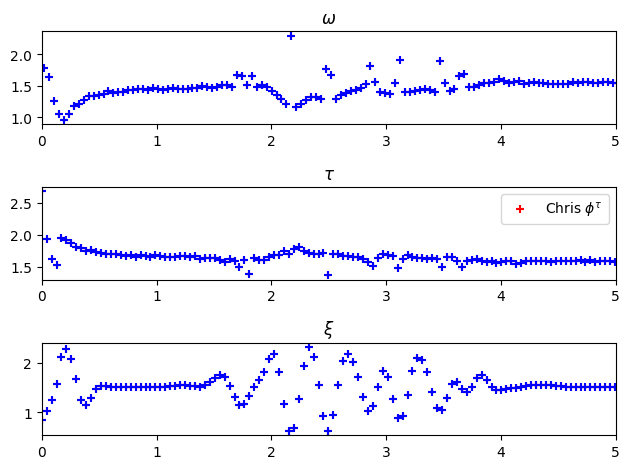

In [12]:
plt.figure()
plt.subplot(3, 1, 1)
# plt.plot(
#     freqAVG / 1000,
#     storePDomegaAVG,
#     linestyle="--",
#     marker=markB,
#     color="r",
#     label=r"Chris $\phi^{\omega}$",
# )
# plt.plot(f_omega / 1000, avg_abs_pd_omega, linestyle="--", marker=markB, color="b")
plt.scatter(
    freqAVG / 1000,
    storePDomegaAVG,
    marker=markB,
    color="r",
    label=r"Chris $\phi^{\omega}$",
)
plt.scatter(f_omega / 1000, avg_abs_pd_omega, marker=markB, color="b")
plt.xlim(0, 5)
plt.title(r"$\omega$")
plt.subplot(3, 1, 2)
# plt.plot(
#     freq / 1000,
#     storePDtauAVG,
#     linestyle="-",
#     marker=markA,
#     color="r",
#     label=r"Chris $\phi^{\tau}$",
# )
# plt.plot(f_tau / 1000, avg_abs_pd_tau, linestyle="--", marker=markB, color="b")
plt.scatter(
    freq / 1000,
    storePDtauAVG,
    marker=markB,
    color="r",
    label=r"Chris $\phi^{\tau}$",
)
plt.scatter(f_tau / 1000, avg_abs_pd_tau, marker=markB, color="b")
plt.legend()
plt.xlim(0, 5)
plt.title(r"$\tau$")

plt.subplot(3, 1, 3)
# plt.plot(
#     freq / 1000,
#     storePDxiAVG,
#     linestyle="-.",
#     marker=markC,
#     color="r",
#     label=r"Chris $\phi^{\xi}$",
#     markersize=2,
# )
# plt.plot(
#     f_xi_phase_corr / 1000,
#     avg_abs_pd_xi_phase_corr,
#     linestyle="--",
#     marker=markB,
#     color="b",
# )
plt.scatter(
    freq / 1000,
    storePDxiAVG,
    marker=markB,
    color="r",
    label=r"Chris $\phi^{\xi}$",
)
plt.scatter(
    f_xi_phase_corr / 1000,
    avg_abs_pd_xi_phase_corr,
    marker=markB,
    color="b",
)
plt.xlim(0, 5)
plt.title(r"$\xi$")
plt.tight_layout()
plt.show